# pyCaret 機器學習完整執行 12 類

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *
import xlwings as xw
import glob

In [2]:
# 選出的五檔基金計算結果

def Calculate_funds(df, funds):

    global Drawdown, earning_strategy, earning, result
    
    # Benchmark（全部的平均）
    bench = df.loc['2019-01-04':'2020-12-31']
    bench_ret = np.log(bench/bench.shift(1))
    bench_ret = bench_ret.mean(axis = 1).to_frame()
    bench_ret.rename(columns = {0:'benchmark'}, inplace = True)

    # Result
    strategy = df.loc['2019-01-04':'2020-12-31'][funds]
    ret_strategy = np.log(strategy/strategy.shift(1))
    ret_strategy['benchmark'] = bench_ret
    ret_strategy.fillna(0, inplace = True)
    earning_strategy = ret_strategy.cumsum()
    earning = 100 * (1 + earning_strategy)
    
    # Drawdown
    Drawdown = pd.DataFrame()
    for k in earning_strategy.columns:
        strategy_ret = earning_strategy[[k]]
        li = []
        for i in range(len(strategy_ret)):
            li.append(strategy_ret.iloc[i,0] - strategy_ret.iloc[:i,0].max())
        li[0] = 0
        each_drawdown = pd.DataFrame(li, index=strategy_ret.index)
        each_drawdown.rename(columns={0:k}, inplace = True)
        for j in range(len(each_drawdown)):
            if each_drawdown.iloc[j,0] > 0:
                each_drawdown.iloc[j] = 0
        Drawdown = pd.concat([Drawdown, each_drawdown], axis = 1)
    
    # Calculate
    max_drawdown = abs(Drawdown.min())
    accumulation_return = earning_strategy.iloc[-1]
    accumulation_return.name = None
    annual_return = ret_strategy.mean() * 365
    annual_volatility = ret_strategy.std() * np.sqrt(365)
    neg_annual_volatility = ret_strategy.applymap(lambda x: 0 if x > 0 else x).std() * np.sqrt(365)
    sharpe_ratio = annual_return / annual_volatility
    sortino_ratio = annual_return / neg_annual_volatility
    calmar_ratio = annual_return / max_drawdown
    
    result = pd.DataFrame([accumulation_return, annual_return, 
                           annual_volatility, neg_annual_volatility,
                           max_drawdown, sharpe_ratio,
                           sortino_ratio, calmar_ratio],  
                          index = ['Accumulation Return', 'Annual Return',
                                   'Annual Volatility', 'Negative Annual Volatility',
                                   'Max Drawdown', 'Sharpe Ratio',
                                   'Sortino Ratio', 'Calmar Ratio']).transpose()
    return

In [3]:
# 將圖片及數據寫入Excel
def save_excel(sheet_name):   
    sheet = workbook.sheets.add()
    sheet.name = sheet_name
    
    sheet.range('A1').value = result
    sheet.range('A10').value = earning
    
    ax = earning_strategy.plot(title = sheet_name)
    fig1 = ax.get_figure()
    plt.grid(True)
    sheet.pictures.add(fig1, name='MyPlot1', update=True, 
                       left=sheet.range('K1').left,
                       top=sheet.range('K1').top) 
    
    plt.cla() # 畫新圖前，要先清空畫本
    ax1 = Drawdown['benchmark'].plot.area(stacked=False, color = 'red', alpha=0.45, title = 'Drawdown')
    ax2 = Drawdown.drop(columns = 'benchmark').plot(ax=ax1, linewidth = 1.5)
    fig2 = ax2.get_figure()
    sheet.pictures.add(fig2, name='MyPlot2', update=True, 
                       left=sheet.range('K22').left, 
                       top=sheet.range('K22').top)
    return

In [4]:
path = "/Users/alex_chiang/Documents/Fin_tech/AI基金/"

files_value = sorted(glob.glob(path + 'classified/*.csv'))
files_ML = sorted(glob.glob(path + 'data_ML/*.csv'))
file_name = [i.split('/')[-1].split('.csv')[0] for i in files_ML]

## 開始執行

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0974,0.0142,0.1191,-1.7996,0.0523,10.6067
1,0.0620,0.0060,0.0777,-1.2987,0.0395,10.5931
2,0.0593,0.0053,0.0725,-0.0004,0.0498,4.9642
3,0.0356,0.0020,0.0452,-0.2686,0.0406,2.7153
4,0.0592,0.0050,0.0704,-0.6354,0.0622,1.4143
5,0.0627,0.0060,0.0773,-0.4488,0.0676,2.5978
6,0.0776,0.0080,0.0893,-2.1387,0.0805,0.9958
7,0.0625,0.0069,0.0828,-0.4246,0.0377,5.0279
8,0.0458,0.0032,0.0567,-0.0419,0.0443,2.7741
9,0.0658,0.0067,0.0817,-0.0093,0.0600,3.9130


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.1252,0.0177,0.1331,-7.1678,0.1178,0.6511


Transformation Pipeline and Model Succesfully Saved


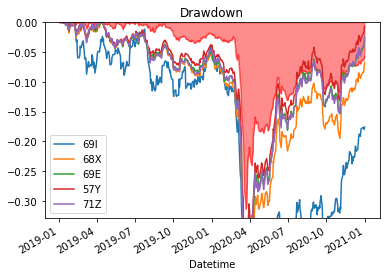

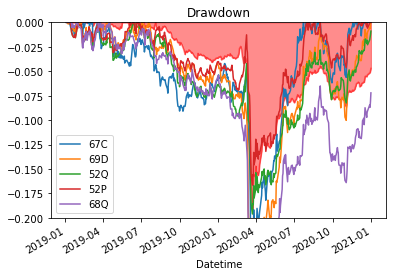

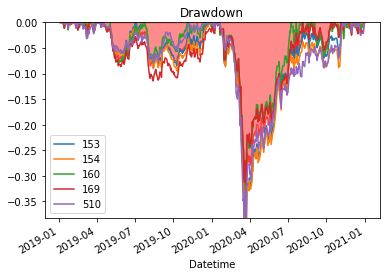

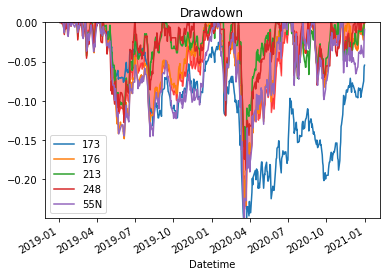

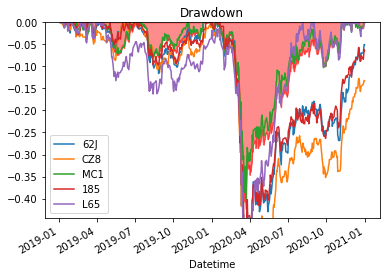

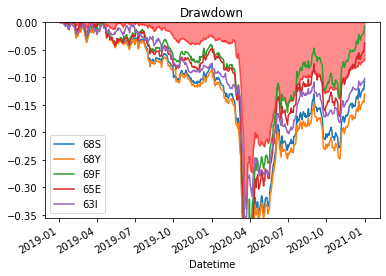

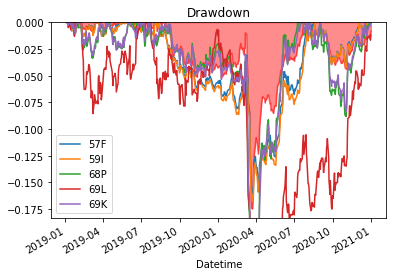

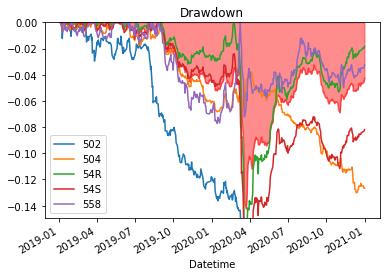

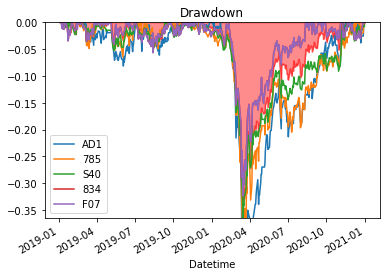

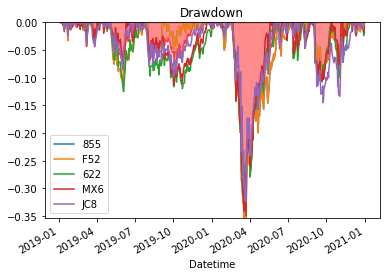

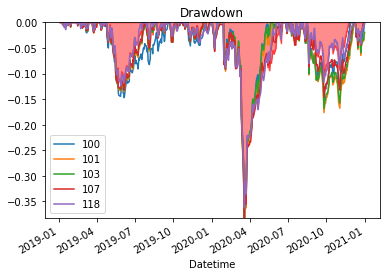

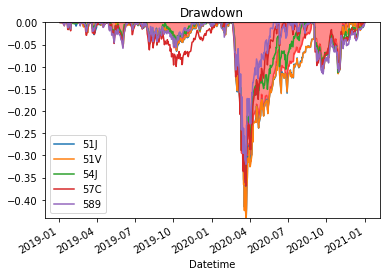

In [5]:
workbook = xw.Book()

for i,j,k in zip(files_value, files_ML, file_name):

    # Set up data
    df = pd.read_csv(i, parse_dates = True, index_col = 'Datetime')
    fund_id = df.columns
    
    df_XY = pd.read_csv(j, parse_dates = True, index_col = ['Datetime', 'fund_id'])
    df_XY.sort_index(level = 0, inplace = True)

    train_data = df_XY.iloc[:-len(df_XY.xs('2019-01-04').index)]
    test_data = df_XY.iloc[-len(df_XY.xs('2019-01-04').index):]
    setup(data = train_data, target = 'Y_ret', test_data = test_data,
          pca = True, pca_components = 3, silent = True, verbose = False)

    # Modeling & get result
    best_model = compare_models()
    tuned_best = tune_model(best_model)
    df_predict = pd.DataFrame(predict_model(tuned_best)['Label'])
    df_predict.index = test_data.xs('2019-01-04').index
    funds = df_predict.nlargest(5, 'Label').index
    Calculate_funds(df = df, funds = funds)

    # save model and result
    save_model(tuned_best, model_name = path+'ML_result/pyCaret_model/'+k+'_model')
    save_excel(sheet_name = k)
    
workbook.save(path + 'ML_result/ML_pyCaret_result.xlsx')
workbook.close()